## Mod 2 Final Project: Predicting the Price of a Diamond.

data dictionary:
* price price in US dollars (\$326--\$18,823)
* carat weight of the diamond (0.2--5.01)
* cut quality of the cut (Fair, Good, Very Good, Premium, Ideal)
* color diamond colour, from J (worst) to D (best)
* clarity a measurement of how clear the diamond is (I1 (worst), SI2, SI1, VS2, VS1, VVS2, VVS1, IF (best))
* x length in mm (0--10.74)
* y width in mm (0--58.9)
* z depth in mm (0--31.8)
* depth total depth percentage = z / mean(x, y) = 2 * z / (x + y) (43--79)
* table width of top of diamond relative to widest point (43--95)




In [1]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.formula.api import ols
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.dummy import DummyRegressor
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
pd.set_option('display.max_columns', None)

In [2]:
# read in data
df = pd.read_csv('./diamonds.csv', index_col=0)
df.head()

carat      cut color clarity  depth  table  price     x     y     z
1   0.23    Ideal     E     SI2   61.5   55.0    326  3.95  3.98  2.43
2   0.21  Premium     E     SI1   59.8   61.0    326  3.89  3.84  2.31
3   0.23     Good     E     VS1   56.9   65.0    327  4.05  4.07  2.31
4   0.29  Premium     I     VS2   62.4   58.0    334  4.20  4.23  2.63
5   0.31     Good     J     SI2   63.3   58.0    335  4.34  4.35  2.75

In [3]:
df.describe()

carat         depth         table         price             x  \
count  53940.000000  53940.000000  53940.000000  53940.000000  53940.000000   
mean       0.797940     61.749405     57.457184   3932.799722      5.731157   
std        0.474011      1.432621      2.234491   3989.439738      1.121761   
min        0.200000     43.000000     43.000000    326.000000      0.000000   
25%        0.400000     61.000000     56.000000    950.000000      4.710000   
50%        0.700000     61.800000     57.000000   2401.000000      5.700000   
75%        1.040000     62.500000     59.000000   5324.250000      6.540000   
max        5.010000     79.000000     95.000000  18823.000000     10.740000   

                  y             z  
count  53940.000000  53940.000000  
mean       5.734526      3.538734  
std        1.142135      0.705699  
min        0.000000      0.000000  
25%        4.720000      2.910000  
50%        5.710000      3.530000  
75%        6.540000      4.040000  
max       58.900000     31.800000

In [4]:
df.isna().sum()

carat      0
cut        0
color      0
clarity    0
depth      0
table      0
price      0
x          0
y          0
z          0
dtype: int64

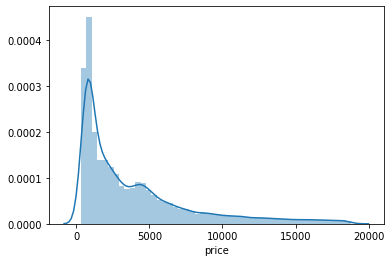

In [5]:
sns.distplot(df.price);

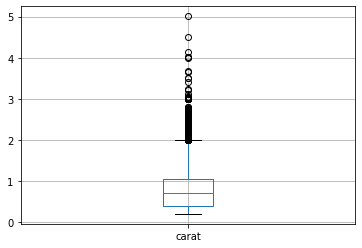

In [6]:
df.boxplot(['carat']);

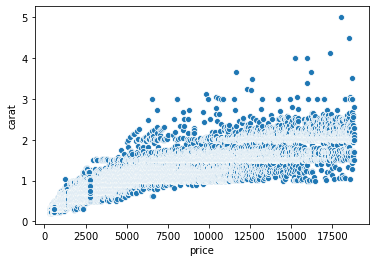

In [7]:
sns.scatterplot(df.price, df.carat)
plt.show();

In [8]:
df.shape

(53940, 10)

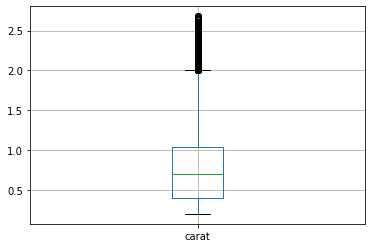

In [9]:
# remove diamonds with carat 4 standard deviations away from mean

carat_mean = df.carat.mean()
carat_std = df.carat.std()

df = df[(df.carat < (carat_mean + (4 * carat_std))) & (df.carat > (carat_mean - (4 * carat_std)))]
df.boxplot(['carat']);

In [10]:
# ANOVA test to tell diff in price based on different categories
# price v. color category



In [11]:
target = df.price

df_cont = df[['carat', 'depth',	'table', 'x', 'y', 'z']]
poly = PolynomialFeatures(degree=2, include_bias=False)
poly_data = poly.fit_transform(df_cont)
poly_columns = poly.get_feature_names(df_cont.columns)
df_poly = pd.DataFrame(poly_data, columns=poly_columns)
df_poly.head()


carat  depth  table     x     y     z  carat^2  carat depth  carat table  \
0   0.23   61.5   55.0  3.95  3.98  2.43   0.0529       14.145        12.65   
1   0.21   59.8   61.0  3.89  3.84  2.31   0.0441       12.558        12.81   
2   0.23   56.9   65.0  4.05  4.07  2.31   0.0529       13.087        14.95   
3   0.29   62.4   58.0  4.20  4.23  2.63   0.0841       18.096        16.82   
4   0.31   63.3   58.0  4.34  4.35  2.75   0.0961       19.623        17.98   

   carat x  carat y  carat z  depth^2  depth table  depth x  depth y  depth z  \
0   0.9085   0.9154   0.5589  3782.25       3382.5  242.925  244.770  149.445   
1   0.8169   0.8064   0.4851  3576.04       3647.8  232.622  229.632  138.138   
2   0.9315   0.9361   0.5313  3237.61       3698.5  230.445  231.583  131.439   
3   1.2180   1.2267   0.7627  3893.76       3619.2  262.080  263.952  164.112   
4   1.3454   1.3485   0.8525  4006.89       3671.4  274.722  275.355  174.075   

   table^2  table x  table y  table z      x^2      x y      x z      y^2  \
0   3025.0   217.25   218.90   133.65  15.6025  15.7210   9.5985  15.8404   
1   3721.0   237.29   234.24   140.91  15.1321  14.9376   8.9859  14.7456   
2   4225.0   263.25   264.55   150.15  16.4025  16.4835   9.3555  16.5649   
3   3364.0   243.60   245.34   152.54  17.6400  17.7660  11.0460  17.8929   
4   3364.0   251.72   252.30   159.50  18.8356  18.8790  11.9350  18.9225   

       y z     z^2  
0   9.6714  5.9049  
1   8.8704  5.3361  
2   9.4017  5.3361  
3  11.1249  6.9169  
4  11.9625  7.5625

In [12]:
X_train, X_test, y_train, y_test = train_test_split(df_cont, target, random_state=34,test_size=0.2)

dummy_regr = DummyRegressor(strategy="mean")
dummy_regr.fit(X_train, y_train)

dummy_train_preds = dummy_regr.predict(X_train)
dummy_test_preds = dummy_regr.predict(X_test)


In [13]:
#your code here 
scaler = StandardScaler()

# fit the scaler to the training data
scaler.fit(X_train)

#transform the training data
X_train = pd.DataFrame(data=scaler.transform(X_train), columns=df_cont.columns)

#transform the testing data
X_test = pd.DataFrame(data=scaler.transform(X_test), columns=df_cont.columns)

In [14]:
baseline = np.sqrt(metrics.mean_squared_error(y_test, dummy_test_preds))
baseline

3989.820102954273

In [15]:
X_train.mean()

carat    6.030266e-17
depth   -8.572748e-15
table   -2.646119e-16
x        6.753202e-16
y       -2.123483e-16
z       -4.678188e-17
dtype: float64

In [16]:
df.price.mean()

3922.368901590365

In [17]:
lm = LinearRegression()
lm = lm.fit(X_train, y_train)

y_train_pred = lm.predict(X_train) # predictions multiplied by actual value
train_rmse = np.sqrt(metrics.mean_squared_error(y_train, y_train_pred))
print('Training Root Mean Squared Error:' , train_rmse)

y_pred = lm.predict(X_test)
test_rmse = np.sqrt(metrics.mean_squared_error(y_test, y_pred))
print('Testing Root Mean Squared Error:' , test_rmse)

Training Root Mean Squared Error: 1452.589917565248
Testing Root Mean Squared Error: 1454.9427398770472


In [18]:
lm.coef_

array([ 5479.20532265,  -307.83104784,  -231.09897368, -1853.44096422,
          30.72545922,    20.83476193])

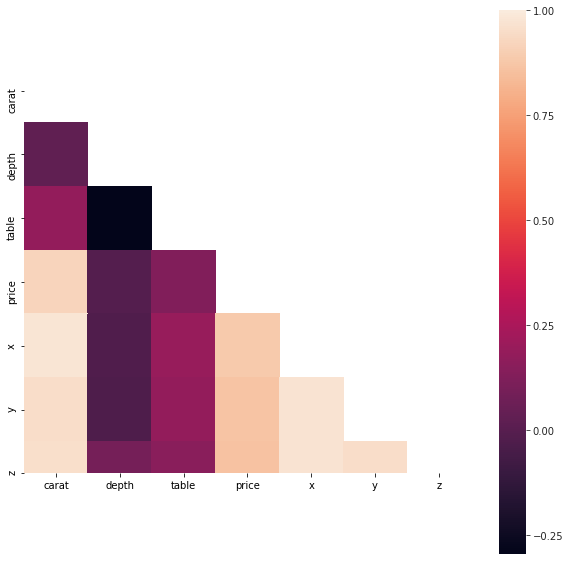

In [19]:
# check for multicolinearity

df.corr()

f, ax = plt.subplots(figsize=(10, 10))
mask = np.zeros_like(df.corr())
mask[np.triu_indices_from(mask)] = True

with sns.axes_style('white'):
    ax = sns.heatmap(df.corr(), mask= mask, square=True)


In [20]:
mlr_model = ols(formula='price~carat+table+x+y+z+depth', data=df).fit()
mlr_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.866
Model:                            OLS   Adj. R-squared:                  0.866
Method:                 Least Squares   F-statistic:                 5.825e+04
Date:                Thu, 30 Jul 2020   Prob (F-statistic):               0.00
Time:                        15:30:15   Log-Likelihood:            -4.6884e+05
No. Observations:               53887   AIC:                         9.377e+05
Df Residuals:                   53880   BIC:                         9.377e+05
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   2.303e+04    437.131     52.684      0.000    2.22e+04    2.39e+04
carat       1.169e+04     63.969    182.696      0.000    1.16e+04    1.18e+04
table       -103.8047      2.996    -34.649      0.000    -109.677     -97.933
x          -1675.2276     42.451    -39.462      0.000   -1758.432   -1592.023
y             43.7373     24.786      1.765      0.078      -4.843      92.317
z             43.6874     43.621      1.002      0.317     -41.809     129.184
depth       -214.6052      5.368    -39.980      0.000    -225.126    -204.084
==============================================================================
Omnibus:                    16064.338   Durbin-Watson:                   1.280
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           196527.360
Skew:                           1.086   Prob(JB):                         0.00
Kurtosis:                      12.100   Cond. No.                     5.94e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.94e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [21]:
# remove y z data for bc they are colinear
df.drop(columns=['y', 'z'], inplace=True)

In [22]:
# create dummy variables

df = pd.get_dummies(df, columns=['cut', 'clarity', 'color'])

In [23]:
df.head()

carat  depth  table  price     x  cut_Fair  cut_Good  cut_Ideal  \
1   0.23   61.5   55.0    326  3.95         0         0          1   
2   0.21   59.8   61.0    326  3.89         0         0          0   
3   0.23   56.9   65.0    327  4.05         0         1          0   
4   0.29   62.4   58.0    334  4.20         0         0          0   
5   0.31   63.3   58.0    335  4.34         0         1          0   

   cut_Premium  cut_Very Good  clarity_I1  clarity_IF  clarity_SI1  \
1            0              0           0           0            0   
2            1              0           0           0            1   
3            0              0           0           0            0   
4            1              0           0           0            0   
5            0              0           0           0            0   

   clarity_SI2  clarity_VS1  clarity_VS2  clarity_VVS1  clarity_VVS2  color_D  \
1            1            0            0             0             0        0   
2            0            0            0             0             0        0   
3            0            1            0             0             0        0   
4            0            0            1             0             0        0   
5            1            0            0             0             0        0   

   color_E  color_F  color_G  color_H  color_I  color_J  
1        1        0        0        0        0        0  
2        1        0        0        0        0        0  
3        1        0        0        0        0        0  
4        0        0        0        0        1        0  
5        0        0        0        0        0        1

In [24]:
    
import pandas as pd
import numpy as np
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
X = df.drop(['price'], axis=1)  #independent columns
y = target  #target column i.e price range

# use f-score
bestfeatures = SelectKBest(score_func=chi2, k=10)
fit = bestfeatures.fit(X,y)

dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)

#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']  #naming the dataframe columns

In [25]:
featureScores

Specs         Score
0           carat  14239.086184
1           depth    441.523576
2           table   1250.668444
3               x  11276.119791
4        cut_Fair  13694.477748
5        cut_Good  12093.201273
6       cut_Ideal   9512.461443
7     cut_Premium  11632.056413
8   cut_Very Good  11813.051705
9      clarity_I1  13838.728474
10     clarity_IF  17589.854955
11    clarity_SI1  15336.163443
12    clarity_SI2  18140.426051
13    clarity_VS1  14900.451935
14    clarity_VS2  15662.721065
15   clarity_VVS1  15277.354430
16   clarity_VVS2  16263.805632
17        color_D  16452.629923
18        color_E  14600.245627
19        color_F  14825.423804
20        color_G  14294.674645
21        color_H  15536.255470
22        color_I  16476.612168
23        color_J  18873.657559

In [26]:
print(featureScores.nlargest(15,'Score'))  #print 15 best features


Specs         Score
23       color_J  18873.657559
12   clarity_SI2  18140.426051
10    clarity_IF  17589.854955
22       color_I  16476.612168
17       color_D  16452.629923
16  clarity_VVS2  16263.805632
14   clarity_VS2  15662.721065
21       color_H  15536.255470
11   clarity_SI1  15336.163443
15  clarity_VVS1  15277.354430
13   clarity_VS1  14900.451935
19       color_F  14825.423804
18       color_E  14600.245627
20       color_G  14294.674645
0          carat  14239.086184


In [27]:
# create model with selected features

feature_selected_df =  df[['color_J',
    'clarity_SI2',
    'clarity_IF',
    'color_I',
    'color_D',
    'clarity_VVS2',
    'clarity_VS2',
    'color_H',
    'clarity_SI1',
    'clarity_VVS1',
    'clarity_VS1',
    'color_F',
    'color_E',
    'color_G',
    'carat']]
X_train, X_test, y_train, y_test = train_test_split(feature_selected_df, target, random_state=34,test_size=0.2)

lm.fit(feature_selected_df, y_test)
foo = lm.predict(feature_selected_df)


ValueError: Found input variables with inconsistent numbers of samples: [53887, 10778]

In [28]:
# confidence interval

